In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from google.cloud import bigquery
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_score

In [3]:
# set display options to show all columns
pd.set_option('display.max_columns', None)
# Set the float format to display numbers without scientific notation
pd.options.display.float_format = '{:.2f}'.format
# Set the client for future queries to BigQuery
client = bigquery.Client(project = "continente-lced-feup")
#data_table.enable_dataframe_formatter()
#auth.authenticate_user()

In [4]:
!gcloud auth application-default login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=oSIKGgswDQgKBc20VEZipAUeudkM8c&access_type=offline&code_challenge=rLcQBlhTFudloxwYU2pchQebjBP2RDdhiYc6IYOg54M&code_challenge_method=S256


Credentials saved to file: [C:\Users\iankk\AppData\Roaming\gcloud\application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Quota project "egd-project" was added to ADC which can be used by Google client libraries for billing and quota. Note that some services may still bill the project owning t

In [5]:
# Feature engineering #
# get transcations data
# total transactions
# total net amount 
# total gross amount
# average amount per transaction
# average number of products per transaction
# average number of days between transactions
# number of different products bought
# Number of different subcategories bought
# number of different categories bought
# average number of sub categories bought per transaction
# average number of products bought per transaction
# average value per product bought

In [6]:
query = client.query("""
   select * from `tables_raw.dim_customer` as customer
where SEG_AGE_DSC = ']25;35]'
   """)

df_customer = query.result().to_dataframe() # Wait for the job to complete.
display(df_customer.head())

,CUSTOMER_ACCOUNT_NR_MASK,GENDER,FAMILY_MEMBERS,CP4,seg_lifestyle_cd,seg_lifestyle_dsc,SEG_AGE,SEG_AGE_DSC,seg_lifestage_cd,seg_lifestage_dsc
0,3237018,M,3,2460,1,Qualidade,SA_3,]25;35],2,Senior
1,12477319,M,5,2580,1,Qualidade,SA_3,]25;35],2,Senior
2,4323319,F,3,2650,1,Qualidade,SA_3,]25;35],2,Senior
3,4671866,F,3,1750,1,Qualidade,SA_3,]25;35],2,Senior
4,13171827,M,3,2720,1,Qualidade,SA_3,]25;35],2,Senior


In [7]:
query = client.query("""
    select * from `tables_raw.dim_customer` as customer
INNER JOIN `tables_raw.fact_transaction` as fct on fct.CUSTOMER_ACCOUNT_NR_MASK = customer.CUSTOMER_ACCOUNT_NR_MASK
where SEG_AGE_DSC = ']25;35]'
LIMIT 1000000
    """)
df_transactions = query.result().to_dataframe() # Wait for the job to complete.
display(df_transactions.head())

,CUSTOMER_ACCOUNT_NR_MASK,GENDER,FAMILY_MEMBERS,CP4,seg_lifestyle_cd,seg_lifestyle_dsc,SEG_AGE,SEG_AGE_DSC,seg_lifestage_cd,seg_lifestage_dsc,TIME_KEY,TRANSACTION_ID_MASK,CUSTOMER_ACCOUNT_NR_MASK_1,LOC_BRAND_CD,LOCATION_CD,POS_TP_CD,SKU,PRODUCT_KEY,QTY,NET_SLS_AMT,GROSS_SLS_AMT,PROD_DSCNT_ISSUED_AMT,TRANS_DSCNT_RAT_AMT,DIRECT_DSCNT_AMT
0,129013193,None,2,1000,1,Qualidade,SA_3,]25;35],5,Active Adults,20220905,8696755899526240802,129013193.00,302,1706,P,7578565,7578565010001,1.00,0.00,0.00,0.00,0.00,1.99
1,8210063,M,4,3860,1,Qualidade,SA_3,]25;35],4,Family with Kids,20220101,7294905030358221300,8210063.00,302,3609,P,4514863,4514863010002,-1.00,0.00,0.00,0.00,0.00,0.00
2,8210063,M,4,3860,1,Qualidade,SA_3,]25;35],4,Family with Kids,20220101,7294905030358221301,8210063.00,302,3609,P,6921736,6921736010001,1.00,0.00,0.00,0.00,0.06,0.00
3,83467563,F,1,None,3,Preço,SA_3,]25;35],1,Family Supporters,20211002,7205975472407762191,83467563.00,302,6154,P,2210961,2210961010001,4.00,2.00,2.12,0.00,0.00,0.52
4,34700409,F,3,5470,2,Família,SA_3,]25;35],4,Family with Kids,20221226,9134159729747363213,34700409.00,302,1703,P,2203136,2203136010003,2.00,2.00,2.12,0.00,0.00,1.02


In [8]:

### Total transactions per client ###
df = pd.DataFrame()
df = df_transactions.groupby('CUSTOMER_ACCOUNT_NR_MASK')['TIME_KEY'].nunique()
df = pd.DataFrame(df).reset_index().rename(columns={'TIME_KEY':'total_transactions'})
df_customer = df_customer.merge(df, on='CUSTOMER_ACCOUNT_NR_MASK', how='left')



In [9]:
df_customer

,CUSTOMER_ACCOUNT_NR_MASK,GENDER,FAMILY_MEMBERS,CP4,seg_lifestyle_cd,seg_lifestyle_dsc,SEG_AGE,SEG_AGE_DSC,seg_lifestage_cd,seg_lifestage_dsc,total_transactions
0,3237018,M,3,2460,1,Qualidade,SA_3,]25;35],2,Senior,40.00
1,12477319,M,5,2580,1,Qualidade,SA_3,]25;35],2,Senior,17.00
2,4323319,F,3,2650,1,Qualidade,SA_3,]25;35],2,Senior,41.00
3,4671866,F,3,1750,1,Qualidade,SA_3,]25;35],2,Senior,83.00
4,13171827,M,3,2720,1,Qualidade,SA_3,]25;35],2,Senior,100.00
...,...,...,...,...,...,...,...,...,...,...,...
12919,62861855,M,<NA>,4520,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,9.00
12920,50687926,M,<NA>,4745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,1.00
12921,119273374,F,<NA>,2745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,3.00
12922,125331917,None,<NA>,1150,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,NaN


In [10]:
### Total Net amount per client ###
df = pd.DataFrame()
df = df_transactions.groupby('CUSTOMER_ACCOUNT_NR_MASK')['NET_SLS_AMT'].sum()
df = pd.DataFrame(df).reset_index().rename(columns={'NET_SLS_AMT':'total_net_amount'})
df_customer = df_customer.merge(df, on='CUSTOMER_ACCOUNT_NR_MASK', how='left')



In [11]:
df_customer

,CUSTOMER_ACCOUNT_NR_MASK,GENDER,FAMILY_MEMBERS,CP4,seg_lifestyle_cd,seg_lifestyle_dsc,SEG_AGE,SEG_AGE_DSC,seg_lifestage_cd,seg_lifestage_dsc,total_transactions,total_net_amount
0,3237018,M,3,2460,1,Qualidade,SA_3,]25;35],2,Senior,40.00,139.88
1,12477319,M,5,2580,1,Qualidade,SA_3,]25;35],2,Senior,17.00,136.48
2,4323319,F,3,2650,1,Qualidade,SA_3,]25;35],2,Senior,41.00,286.81
3,4671866,F,3,1750,1,Qualidade,SA_3,]25;35],2,Senior,83.00,1179.09
4,13171827,M,3,2720,1,Qualidade,SA_3,]25;35],2,Senior,100.00,708.24
...,...,...,...,...,...,...,...,...,...,...,...,...
12919,62861855,M,<NA>,4520,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,9.00,105.21
12920,50687926,M,<NA>,4745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,1.00,12.15
12921,119273374,F,<NA>,2745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,3.00,33.23
12922,125331917,None,<NA>,1150,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,NaN,NaN


In [12]:
### Total Gross amount per client ###
df = pd.DataFrame()
df = df_transactions.groupby('CUSTOMER_ACCOUNT_NR_MASK')['GROSS_SLS_AMT'].sum()
df = pd.DataFrame(df).reset_index().rename(columns={'GROSS_SLS_AMT':'total_gross_amount'})
df_customer = df_customer.merge(df, on='CUSTOMER_ACCOUNT_NR_MASK', how='left')


In [13]:
df_customer

,CUSTOMER_ACCOUNT_NR_MASK,GENDER,FAMILY_MEMBERS,CP4,seg_lifestyle_cd,seg_lifestyle_dsc,SEG_AGE,SEG_AGE_DSC,seg_lifestage_cd,seg_lifestage_dsc,total_transactions,total_net_amount,total_gross_amount
0,3237018,M,3,2460,1,Qualidade,SA_3,]25;35],2,Senior,40.00,139.88,161.99
1,12477319,M,5,2580,1,Qualidade,SA_3,]25;35],2,Senior,17.00,136.48,160.82
2,4323319,F,3,2650,1,Qualidade,SA_3,]25;35],2,Senior,41.00,286.81,329.57
3,4671866,F,3,1750,1,Qualidade,SA_3,]25;35],2,Senior,83.00,1179.09,1363.96
4,13171827,M,3,2720,1,Qualidade,SA_3,]25;35],2,Senior,100.00,708.24,802.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12919,62861855,M,<NA>,4520,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,9.00,105.21,125.57
12920,50687926,M,<NA>,4745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,1.00,12.15,14.94
12921,119273374,F,<NA>,2745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,3.00,33.23,38.94
12922,125331917,None,<NA>,1150,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,NaN,NaN,NaN


In [14]:
### Average amount per transaction per customer and per day ###
df = pd.DataFrame()
df = df_transactions.groupby(['CUSTOMER_ACCOUNT_NR_MASK', 'TIME_KEY'])['NET_SLS_AMT'].mean()
df = df.groupby('CUSTOMER_ACCOUNT_NR_MASK').mean()
df = df.drop(columns=['TIME_KEY'])
df = pd.DataFrame(df).reset_index().rename(columns={'NET_SLS_AMT':'avg_amount_per_transaction'})
df_customer = df_customer.merge(df, on='CUSTOMER_ACCOUNT_NR_MASK', how='left')

In [15]:
df_customer

,CUSTOMER_ACCOUNT_NR_MASK,GENDER,FAMILY_MEMBERS,CP4,seg_lifestyle_cd,seg_lifestyle_dsc,SEG_AGE,SEG_AGE_DSC,seg_lifestage_cd,seg_lifestage_dsc,total_transactions,total_net_amount,total_gross_amount,avg_amount_per_transaction
0,3237018,M,3,2460,1,Qualidade,SA_3,]25;35],2,Senior,40.00,139.88,161.99,2.15
1,12477319,M,5,2580,1,Qualidade,SA_3,]25;35],2,Senior,17.00,136.48,160.82,3.95
2,4323319,F,3,2650,1,Qualidade,SA_3,]25;35],2,Senior,41.00,286.81,329.57,3.09
3,4671866,F,3,1750,1,Qualidade,SA_3,]25;35],2,Senior,83.00,1179.09,1363.96,2.89
4,13171827,M,3,2720,1,Qualidade,SA_3,]25;35],2,Senior,100.00,708.24,802.47,3.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12919,62861855,M,<NA>,4520,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,9.00,105.21,125.57,6.49
12920,50687926,M,<NA>,4745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,1.00,12.15,14.94,6.07
12921,119273374,F,<NA>,2745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,3.00,33.23,38.94,7.10
12922,125331917,None,<NA>,1150,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,NaN,NaN,NaN,NaN


In [16]:
### Average number of products per transaction per customer and per day ###
df = pd.DataFrame()
df = df_transactions.groupby(['CUSTOMER_ACCOUNT_NR_MASK', 'TIME_KEY'])['TRANSACTION_ID_MASK'].count()
df = df.groupby('CUSTOMER_ACCOUNT_NR_MASK').mean()
df = pd.DataFrame(df).reset_index().rename(columns={'TRANSACTION_ID_MASK':'avg_number_of_products_per_transaction'})
df_customer = df_customer.merge(df, on='CUSTOMER_ACCOUNT_NR_MASK', how='left')

In [17]:
df_customer

,CUSTOMER_ACCOUNT_NR_MASK,GENDER,FAMILY_MEMBERS,CP4,seg_lifestyle_cd,seg_lifestyle_dsc,SEG_AGE,SEG_AGE_DSC,seg_lifestage_cd,seg_lifestage_dsc,total_transactions,total_net_amount,total_gross_amount,avg_amount_per_transaction,avg_number_of_products_per_transaction
0,3237018,M,3,2460,1,Qualidade,SA_3,]25;35],2,Senior,40.00,139.88,161.99,2.15,1.52
1,12477319,M,5,2580,1,Qualidade,SA_3,]25;35],2,Senior,17.00,136.48,160.82,3.95,2.35
2,4323319,F,3,2650,1,Qualidade,SA_3,]25;35],2,Senior,41.00,286.81,329.57,3.09,2.41
3,4671866,F,3,1750,1,Qualidade,SA_3,]25;35],2,Senior,83.00,1179.09,1363.96,2.89,5.57
4,13171827,M,3,2720,1,Qualidade,SA_3,]25;35],2,Senior,100.00,708.24,802.47,3.08,2.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12919,62861855,M,<NA>,4520,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,9.00,105.21,125.57,6.49,3.33
12920,50687926,M,<NA>,4745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,1.00,12.15,14.94,6.07,2.00
12921,119273374,F,<NA>,2745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,3.00,33.23,38.94,7.10,2.00
12922,125331917,None,<NA>,1150,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,NaN,NaN,NaN,NaN,NaN


In [18]:
### Average number of days between transactions per customer ###
df = pd.DataFrame()
df = df_transactions.groupby(['CUSTOMER_ACCOUNT_NR_MASK'])['TIME_KEY'].apply(lambda x: x.sort_values().diff().mean())
df = pd.DataFrame(df).reset_index().rename(columns={'TIME_KEY':'avg_number_of_days_between_transactions'})
df_customer = df_customer.merge(df, on='CUSTOMER_ACCOUNT_NR_MASK', how='left')


In [19]:
df_customer

,CUSTOMER_ACCOUNT_NR_MASK,GENDER,FAMILY_MEMBERS,CP4,seg_lifestyle_cd,seg_lifestyle_dsc,SEG_AGE,SEG_AGE_DSC,seg_lifestage_cd,seg_lifestage_dsc,total_transactions,total_net_amount,total_gross_amount,avg_amount_per_transaction,avg_number_of_products_per_transaction,avg_number_of_days_between_transactions
0,3237018,M,3,2460,1,Qualidade,SA_3,]25;35],2,Senior,40.00,139.88,161.99,2.15,1.52,185.17
1,12477319,M,5,2580,1,Qualidade,SA_3,]25;35],2,Senior,17.00,136.48,160.82,3.95,2.35,274.87
2,4323319,F,3,2650,1,Qualidade,SA_3,]25;35],2,Senior,41.00,286.81,329.57,3.09,2.41,113.20
3,4671866,F,3,1750,1,Qualidade,SA_3,]25;35],2,Senior,83.00,1179.09,1363.96,2.89,5.57,23.87
4,13171827,M,3,2720,1,Qualidade,SA_3,]25;35],2,Senior,100.00,708.24,802.47,3.08,2.27,49.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12919,62861855,M,<NA>,4520,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,9.00,105.21,125.57,6.49,3.33,382.83
12920,50687926,M,<NA>,4745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,1.00,12.15,14.94,6.07,2.00,0.00
12921,119273374,F,<NA>,2745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,3.00,33.23,38.94,7.10,2.00,63.20
12922,125331917,None,<NA>,1150,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
### Number of different products bought per customer ###
df = pd.DataFrame()
df = df_transactions.groupby(['CUSTOMER_ACCOUNT_NR_MASK'])['PRODUCT_KEY'].nunique()
df = pd.DataFrame(df).reset_index().rename(columns={'PRODUCT_KEY':'number_of_different_products_bought'})
df_customer = df_customer.merge(df, on='CUSTOMER_ACCOUNT_NR_MASK', how='left')

In [21]:
df_customer

,CUSTOMER_ACCOUNT_NR_MASK,GENDER,FAMILY_MEMBERS,CP4,seg_lifestyle_cd,seg_lifestyle_dsc,SEG_AGE,SEG_AGE_DSC,seg_lifestage_cd,seg_lifestage_dsc,total_transactions,total_net_amount,total_gross_amount,avg_amount_per_transaction,avg_number_of_products_per_transaction,avg_number_of_days_between_transactions,number_of_different_products_bought
0,3237018,M,3,2460,1,Qualidade,SA_3,]25;35],2,Senior,40.00,139.88,161.99,2.15,1.52,185.17,48.00
1,12477319,M,5,2580,1,Qualidade,SA_3,]25;35],2,Senior,17.00,136.48,160.82,3.95,2.35,274.87,40.00
2,4323319,F,3,2650,1,Qualidade,SA_3,]25;35],2,Senior,41.00,286.81,329.57,3.09,2.41,113.20,96.00
3,4671866,F,3,1750,1,Qualidade,SA_3,]25;35],2,Senior,83.00,1179.09,1363.96,2.89,5.57,23.87,317.00
4,13171827,M,3,2720,1,Qualidade,SA_3,]25;35],2,Senior,100.00,708.24,802.47,3.08,2.27,49.23,158.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12919,62861855,M,<NA>,4520,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,9.00,105.21,125.57,6.49,3.33,382.83,30.00
12920,50687926,M,<NA>,4745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,1.00,12.15,14.94,6.07,2.00,0.00,2.00
12921,119273374,F,<NA>,2745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,3.00,33.23,38.94,7.10,2.00,63.20,6.00
12922,125331917,None,<NA>,1150,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# average number of products bought per transaction
df = pd.DataFrame()
df = df_transactions.groupby(['CUSTOMER_ACCOUNT_NR_MASK'])['PRODUCT_KEY'].count() / df_transactions.groupby(['CUSTOMER_ACCOUNT_NR_MASK'])['TIME_KEY'].nunique()
df = pd.DataFrame(df).reset_index().rename(columns={0:'avg_number_of_products_bought_per_transaction'})
df_customer = df_customer.merge(df, on='CUSTOMER_ACCOUNT_NR_MASK', how='left')


In [23]:
df_customer

,CUSTOMER_ACCOUNT_NR_MASK,GENDER,FAMILY_MEMBERS,CP4,seg_lifestyle_cd,seg_lifestyle_dsc,SEG_AGE,SEG_AGE_DSC,seg_lifestage_cd,seg_lifestage_dsc,total_transactions,total_net_amount,total_gross_amount,avg_amount_per_transaction,avg_number_of_products_per_transaction,avg_number_of_days_between_transactions,number_of_different_products_bought,avg_number_of_products_bought_per_transaction
0,3237018,M,3,2460,1,Qualidade,SA_3,]25;35],2,Senior,40.00,139.88,161.99,2.15,1.52,185.17,48.00,1.52
1,12477319,M,5,2580,1,Qualidade,SA_3,]25;35],2,Senior,17.00,136.48,160.82,3.95,2.35,274.87,40.00,2.35
2,4323319,F,3,2650,1,Qualidade,SA_3,]25;35],2,Senior,41.00,286.81,329.57,3.09,2.41,113.20,96.00,2.41
3,4671866,F,3,1750,1,Qualidade,SA_3,]25;35],2,Senior,83.00,1179.09,1363.96,2.89,5.57,23.87,317.00,5.57
4,13171827,M,3,2720,1,Qualidade,SA_3,]25;35],2,Senior,100.00,708.24,802.47,3.08,2.27,49.23,158.00,2.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12919,62861855,M,<NA>,4520,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,9.00,105.21,125.57,6.49,3.33,382.83,30.00,3.33
12920,50687926,M,<NA>,4745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,1.00,12.15,14.94,6.07,2.00,0.00,2.00,2.00
12921,119273374,F,<NA>,2745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,3.00,33.23,38.94,7.10,2.00,63.20,6.00,2.00
12922,125331917,None,<NA>,1150,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# average value per product bought
df = pd.DataFrame()
df = df_transactions.groupby(['CUSTOMER_ACCOUNT_NR_MASK'])['NET_SLS_AMT'].sum() / df_transactions.groupby(['CUSTOMER_ACCOUNT_NR_MASK'])['PRODUCT_KEY'].nunique()
df = pd.DataFrame(df).reset_index().rename(columns={0:'avg_value_per_product_bought'})
df_customer = df_customer.merge(df, on='CUSTOMER_ACCOUNT_NR_MASK', how='left')

In [25]:
df_customer

,CUSTOMER_ACCOUNT_NR_MASK,GENDER,FAMILY_MEMBERS,CP4,seg_lifestyle_cd,seg_lifestyle_dsc,SEG_AGE,SEG_AGE_DSC,seg_lifestage_cd,seg_lifestage_dsc,total_transactions,total_net_amount,total_gross_amount,avg_amount_per_transaction,avg_number_of_products_per_transaction,avg_number_of_days_between_transactions,number_of_different_products_bought,avg_number_of_products_bought_per_transaction,avg_value_per_product_bought
0,3237018,M,3,2460,1,Qualidade,SA_3,]25;35],2,Senior,40.00,139.88,161.99,2.15,1.52,185.17,48.00,1.52,2.91
1,12477319,M,5,2580,1,Qualidade,SA_3,]25;35],2,Senior,17.00,136.48,160.82,3.95,2.35,274.87,40.00,2.35,3.41
2,4323319,F,3,2650,1,Qualidade,SA_3,]25;35],2,Senior,41.00,286.81,329.57,3.09,2.41,113.20,96.00,2.41,2.99
3,4671866,F,3,1750,1,Qualidade,SA_3,]25;35],2,Senior,83.00,1179.09,1363.96,2.89,5.57,23.87,317.00,5.57,3.72
4,13171827,M,3,2720,1,Qualidade,SA_3,]25;35],2,Senior,100.00,708.24,802.47,3.08,2.27,49.23,158.00,2.27,4.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12919,62861855,M,<NA>,4520,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,9.00,105.21,125.57,6.49,3.33,382.83,30.00,3.33,3.51
12920,50687926,M,<NA>,4745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,1.00,12.15,14.94,6.07,2.00,0.00,2.00,2.00,6.07
12921,119273374,F,<NA>,2745,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,3.00,33.23,38.94,7.10,2.00,63.20,6.00,2.00,5.54
12922,125331917,None,<NA>,1150,4,Sem Valor,SA_3,]25;35],3,Family w/ Young Adul,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# Remove cd columns
df_customer.drop(['seg_lifestyle_cd', 'seg_lifestage_cd','SEG_AGE','CUSTOMER_ACCOUNT_NR_MASK','CP4'], axis=1, inplace=True)

In [27]:
### Get Dummies from categorical columns ###
df_customer = pd.get_dummies(df_customer, columns=['SEG_AGE_DSC','seg_lifestyle_dsc','seg_lifestage_dsc','GENDER'])

In [28]:
df_customer.fillna(0, inplace=True)

In [29]:
### to do
# number of different categories bought
# Number of different subcategories bought per customer
# average number of sub categories bought per transaction

In [30]:
model = KMeans(n_clusters=4, random_state=0).fit(df_customer)
model.labels_


array([3, 3, 3, ..., 3, 3, 3])

In [31]:
df_customer

,FAMILY_MEMBERS,total_transactions,total_net_amount,total_gross_amount,avg_amount_per_transaction,avg_number_of_products_per_transaction,avg_number_of_days_between_transactions,number_of_different_products_bought,avg_number_of_products_bought_per_transaction,avg_value_per_product_bought,SEG_AGE_DSC_]25;35],seg_lifestyle_dsc_Família,seg_lifestyle_dsc_Preço,seg_lifestyle_dsc_Qualidade,seg_lifestyle_dsc_Sem Valor,seg_lifestage_dsc_Active Adults,seg_lifestage_dsc_Family Supporters,seg_lifestage_dsc_Family w/ Young Adul,seg_lifestage_dsc_Family with Kids,seg_lifestage_dsc_No Value,seg_lifestage_dsc_Senior,GENDER_F,GENDER_M
0,3,40.00,139.88,161.99,2.15,1.52,185.17,48.00,1.52,2.91,1,0,0,1,0,0,0,0,0,0,1,0,1
1,5,17.00,136.48,160.82,3.95,2.35,274.87,40.00,2.35,3.41,1,0,0,1,0,0,0,0,0,0,1,0,1
2,3,41.00,286.81,329.57,3.09,2.41,113.20,96.00,2.41,2.99,1,0,0,1,0,0,0,0,0,0,1,1,0
3,3,83.00,1179.09,1363.96,2.89,5.57,23.87,317.00,5.57,3.72,1,0,0,1,0,0,0,0,0,0,1,1,0
4,3,100.00,708.24,802.47,3.08,2.27,49.23,158.00,2.27,4.48,1,0,0,1,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12919,0,9.00,105.21,125.57,6.49,3.33,382.83,30.00,3.33,3.51,1,0,0,0,1,0,0,1,0,0,0,0,1
12920,0,1.00,12.15,14.94,6.07,2.00,0.00,2.00,2.00,6.07,1,0,0,0,1,0,0,1,0,0,0,0,1
12921,0,3.00,33.23,38.94,7.10,2.00,63.20,6.00,2.00,5.54,1,0,0,0,1,0,0,1,0,0,0,1,0
12922,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,0,0,0,1,0,0,1,0,0,0,0,0


In [32]:
df_customer['cluster'] = model.labels_

In [44]:
# Define the colors
colors = ['#FD0505', '#970707']

# Create a list of relative positions for each color
positions = [0, 1]

# Create the custom colormap
cmap = mcolors.LinearSegmentedColormap.from_list("", list(zip(positions, colors)))

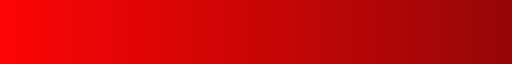

In [45]:
cmap

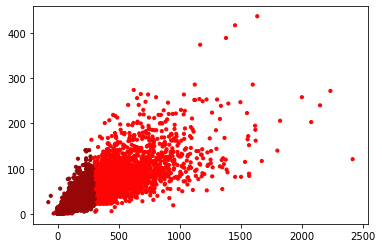

In [46]:
# Plot the clusters obtained using k means
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(df_customer['total_net_amount'],df_customer['total_transactions'], c=df_customer['cluster'],s=10,cmap=cmap)

In [47]:
model_db = DBSCAN().fit(df_customer)

In [48]:
df_customer['cluster_db'] = model_db.labels_

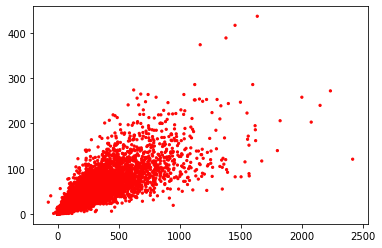

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(df_customer['total_net_amount'],df_customer['total_transactions'], c=df_customer['cluster_db'],s=5,cmap=cmap)

In [50]:
model_birch = Birch(n_clusters=4).fit(df_customer)

In [51]:
df_customer['cluster_birch'] = model_birch.labels_

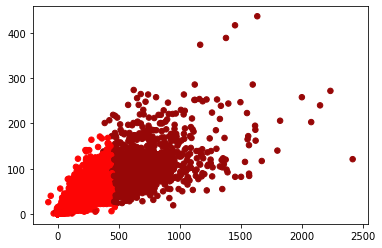

In [52]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(df_customer['total_net_amount'],df_customer['total_transactions'], c=df_customer['cluster_birch'],s=30,cmap=cmap)

In [53]:
model_aff = AffinityPropagation().fit(df_customer)

c:\Users\iankk\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_affinity_propagation.py:236: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


In [54]:
df_customer['cluster_aff'] = model_aff.labels_

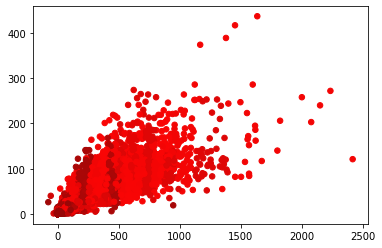

In [55]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(df_customer['total_net_amount'],df_customer['total_transactions'], c=df_customer['cluster_aff'],s=30,cmap=cmap)

In [112]:
display(silhouette_score(df_customer, model.labels_))
display(silhouette_score(df_customer, model_birch.labels_))
display(silhouette_score(df_customer, model_aff.labels_))

0.14931286591252554

0.1740677019240439

0.4219749271893001